In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
# spacy.require_gpu()
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

In [2]:
f = open('/content/drive/MyDrive/Colab Notebooks/NLP/Ticket collection/complaints-2021-05-14_08_16.json')

data = json.load(f)
df=pd.json_normalize(data)

In [3]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
print("Columns are: ", df.columns.values)

Columns are:  ['_index' '_type' '_id' '_score' '_source.tags' '_source.zip_code'
 '_source.complaint_id' '_source.issue' '_source.date_received'
 '_source.state' '_source.consumer_disputed' '_source.product'
 '_source.company_response' '_source.company' '_source.submitted_via'
 '_source.date_sent_to_company' '_source.company_public_response'
 '_source.sub_product' '_source.timely' '_source.complaint_what_happened'
 '_source.sub_issue' '_source.consumer_consent_provided']


In [6]:
#Assign new column names
df.rename(columns={'_index':'index',
  '_type':'type',
  '_id':'id',
  '_score':'score',
  '_source.tags':'tags',
  '_source.zip_code':'',
 '_source.complaint_id':'complaint_id',
 '_source.issue':'issue',
 '_source.date_received':'date_received',
 '_source.state':'state',
 '_source.consumer_disputed':'consumer_disputed',
 '_source.product':'product',
 '_source.company_response':'company_response',
 '_source.company':'company',
 '_source.submitted_via':'submitted_via',
 '_source.date_sent_to_company':'date_sent_to_company',
 '_source.company_public_response':'company_public_response',
 '_source.sub_product':'sub_product',
 '_source.timely':'timely',
 '_source.complaint_what_happened':'complaint_what_happened',
 '_source.sub_issue':'sub_issue',
 '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [7]:
df['complaint_what_happened'].replace('', np.nan, inplace=True)

In [8]:
df['complaint_what_happened'].isnull().sum()

57241

In [9]:
df.dropna(subset=['complaint_what_happened'],inplace=True)

In [10]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text=text.lower()  #convert to lower case
  text=re.sub(r'^\[[\w\s]\]+$',' ',text) #Remove text in square brackets
  text=re.sub(r'[^\w\s]',' ',text) #Remove punctuation
  text=re.sub(r'^[a-zA-Z]\d+\w*$',' ',text) #Remove words with numbers
  return text

In [11]:
#Write your function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lemmatization(texts):
    lemma_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.lemma_ for token in doc if token.text not in set(stopwords)]
        lemma_sentences.append(' '.join(sent))
    return lemma_sentences

In [12]:
df_clean = pd.DataFrame()

In [13]:
df_clean

""


In [14]:
df_clean['complaint_what_happened'] = df['complaint_what_happened'].progress_apply(lambda x: clean_text(x))

100%|██████████| 21072/21072 [00:01<00:00, 15435.30it/s]


In [15]:
df_clean['complaint_what_happened_lemmatized'] = lemmatization(df_clean['complaint_what_happened'])

21072it [13:10, 26.65it/s]


In [16]:
# adding category and sub_category columns to the dataframe for better topic identification
df_clean['category'] = df['product']
df_clean['sub_category'] = df['sub_product']

In [17]:
def extract_pos_tags(texts):
    pos_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.text for token in doc if token.tag_ == 'NN']
        pos_sentences.append(' '.join(sent))
    return pos_sentences

df_clean["complaint_POS_removed"] = extract_pos_tags(df_clean['complaint_what_happened_lemmatized'])

21072it [06:21, 55.23it/s]


In [18]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...


In [19]:
df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()
df_clean['complaint_what_happened_lemmatized_length'] = df_clean['complaint_what_happened_lemmatized'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()

fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_length'], name='Complaint'))
fig.add_trace(go.Histogram(x=df_clean['complaint_what_happened_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='Complaint Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

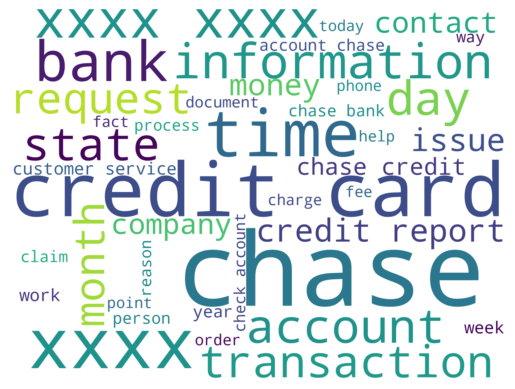

In [20]:
from wordcloud import WordCloud
wordcloud=WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [21]:
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [22]:
def get_top_n_words(corpus, n=None,count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

In [23]:
unigram = get_top_n_words(df_clean['Complaint_clean'], 1,10)
for word, freq in unigram:
    print(word, freq)
px.bar(x=[word for word, freq in unigram], y=[freq for word, freq in unigram], title='Top 10 Unigrams')

chase 58460
xxxx 52900
account 43065
credit 33912
card 30137
payment 21329
bank 19978
time 16233
charge 15387
day 13243


In [24]:
bigram = get_top_n_words(df_clean['Complaint_clean'], 2,10)
for word, freq in bigram:
    print(word, freq)
px.bar(x=[word for word, freq in bigram], y=[freq for word, freq in bigram], title='Top 10 Bigrams')

credit card 12862
xxxx xxxx 6127
credit report 3927
chase credit 3170
customer service 3004
call chase 2956
chase bank 2579
account chase 2507
check account 2349
chase account 2114


In [25]:
trigram = get_top_n_words(df_clean['Complaint_clean'], 3,10)
for word, freq in trigram:
    print(word, freq)
px.bar(x=[word for word, freq in trigram], y=[freq for word, freq in trigram], title='Top 10 Trigram')

chase credit card 2275
xxxx xxxx xxxx 1713
credit card account 1061
credit card company 977
xxxx credit card 825
credit card chase 762
chase customer service 579
credit card xxxx 550
inquiry credit report 472
credit card credit 411


In [26]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [27]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,224,149,94,chase card report application submit identity ...
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,1502,839,409,book ticket ticket reward card information off...
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...


In [28]:
tf_idf_vec=TfidfVectorizer(max_df=0.98,min_df=2,stop_words='english')

In [29]:
tfidf=tf_idf_vec.fit_transform(df_clean['Complaint_clean'])

In [30]:
from sklearn.decomposition import NMF

In [31]:
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [32]:
nmf_model.fit(tfidf)
len(tf_idf_vec.get_feature_names_out())

6257

In [33]:
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index} with tf-idf score')
    print([tf_idf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0 with tf-idf score
['claim', 'customer', 'transaction', 'business', 'number', 'transfer', 'day', 'branch', 'fund', 'chase', 'deposit', 'money', 'bank', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1 with tf-idf score
['service', 'time', 'reason', 'application', 'month', 'point', 'purchase', 'year', 'limit', 'score', 'account', 'balance', 'chase', 'credit', 'card']


THE TOP 15 WORDS FOR TOPIC #2 with tf-idf score
['date', 'statement', 'balance', 'property', 'rate', 'pay', 'year', 'time', 'home', 'modification', 'month', 'chase', 'mortgage', 'loan', 'payment']


THE TOP 15 WORDS FOR TOPIC #3 with tf-idf score
['dispute', 'letter', 'score', 'theft', 'remove', 'file', 'identity', 'account', 'reporting', 'debt', 'information', 'company', 'credit', 'inquiry', 'report']


THE TOP 15 WORDS FOR TOPIC #4 with tf-idf score
['statement', 'time', 'email', 'contact', 'service', 'fraud', 'purchase', 'refund', 'claim', 'merchant', 'transaction', 'chase', 'fee', 'disp

In [34]:
topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis=1)

array([0, 1, 3, ..., 3, 1, 2])

In [35]:
df_clean['Topic'] = topic_values.argmax(axis=1)

In [36]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...,1
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,224,149,94,chase card report application submit identity ...,3
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,1502,839,409,book ticket ticket reward card information off...,3
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...,0


In [37]:
df_clean.groupby('Topic').head(5).sort_values(by='Topic')

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...,0
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,Vehicle loan or lease,Loan,mishandle account chase auto xxxx,51,33,33,mishandle account chase auto,0
17,with out notice j p morgan chase restricted m...,notice j p morgan chase restrict account deb...,Checking or savings account,Checking account,account debit card branch customer service rep...,2277,1315,638,account debit card branch customer service rep...,0
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...,0
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus ...,Checking or savings account,Checking account,account call follow term account xxxx deposit ...,413,202,102,account call follow term account deposit bonu...,0
32,my chase amazon card was declined for a cateri...,chase amazon card decline catering order place...,Credit card or prepaid card,General-purpose credit card or charge card,catering order place contact chase noon today ...,1972,1125,573,catering order place contact chase noon today ...,1
59,i currently have over xxxx chase ultimate rewa...,currently xxxx chase ultimate reward point w...,Credit card or prepaid card,General-purpose credit card or charge card,xxxx reward point month access chase reward ac...,1897,1155,551,reward point month access chase reward accoun...,1
52,my roommate was stealing my chase debit card a...,roommate steal chase debit card driver license...,Checking or savings account,Checking account,roommate chase debit card driver license money...,843,556,210,roommate chase debit card driver license money...,1
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...,1
50,i am a senior citizen that has been scammed by...,senior citizen scamme company xxxx xxxx pay ...,Credit card or prepaid card,General-purpose credit card or charge card,citizen time share company refund credit card ...,350,153,65,citizen time share company refund credit card ...,1


In [38]:
Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic_category'] = df_clean['Topic'].map(Topic_names)

In [39]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic,Topic_category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank service write chase debt ver...,486,311,153,morning help bank service write chase debt ver...,0,Bank Account services
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,upgrade xxxx xxxx card xx xx 2018 tell agent u...,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change age...,355,229,123,card agent upgrade anniversary date change age...,1,Credit card or prepaid card
10,chase card was reported on xx xx 2019 however...,chase card report xx xx 2019 fraudulent ap...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,224,149,94,chase card report application submit identity ...,3,Theft/Dispute Reporting
11,on xx xx 2018 while trying to book a xxxx xx...,xx xx 2018 try book xxxx xxxx ticket c...,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket ticket reward card information off...,1502,839,409,book ticket ticket reward card information off...,3,Theft/Dispute Reporting
14,my grand son give me check for 1600 00 i de...,grand son check 1600 00 deposit chase acc...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,477,304,161,son deposit chase account fund bank account pa...,0,Bank Account services


In [40]:
training_data=df_clean[['complaint_what_happened','Topic']]

In [41]:
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and...,1
10,chase card was reported on xx xx 2019 however...,3
11,on xx xx 2018 while trying to book a xxxx xx...,3
14,my grand son give me check for 1600 00 i de...,0


In [42]:
count_vect=CountVectorizer()
#Write your code to get the Vector count
X_train_counts=count_vect.fit_transform(training_data['complaint_what_happened'])
#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer()
X_train_tf=tfidf_transformer.fit_transform(X_train_counts)

In [43]:
px.bar(x=training_data['Topic'].value_counts().index, y=training_data['Topic'].value_counts().values/max(training_data['Topic'].value_counts().values), title='Class Imbalance')

In [47]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [48]:
train_X, test_X, train_y, test_y = train_test_split(X_train_tf, training_data['Topic'], test_size=0.2, random_state=40)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
train_X_smote, train_y_smote = smote.fit_resample(train_X, train_y)

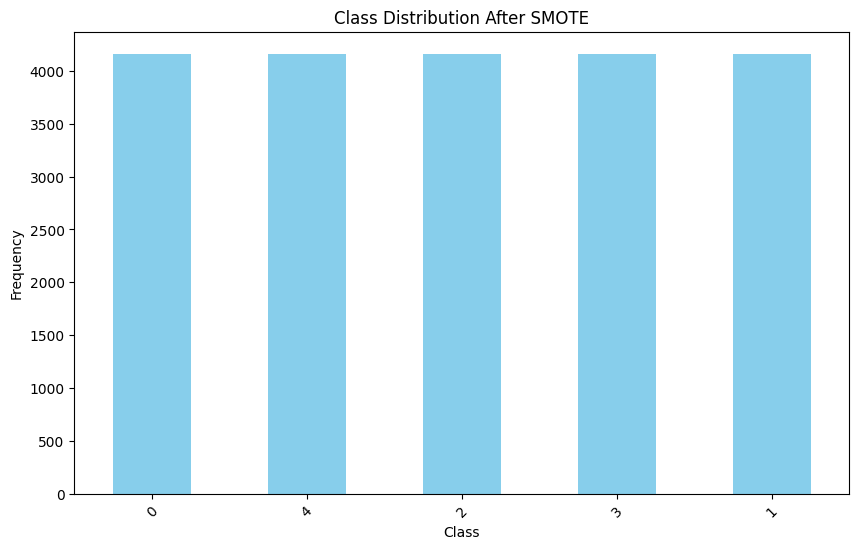

In [49]:
import matplotlib.pyplot as plt

# Check class distribution after SMOTE
class_counts_smote = pd.Series(train_y_smote).value_counts()

# Plot the class distribution
plt.figure(figsize=(10, 6))
class_counts_smote.plot(kind='bar', color='skyblue')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

def print_metrics(y_true, y_pred, model_name, y_proba=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multiclass
    recall = recall_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multiclass
    f1 = f1_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multiclass

    # ROC AUC Score needs binarized labels and probability estimates
    if y_proba is not None:
        num_classes = y_proba.shape[1]
        y_true_binarized = label_binarize(y_true, classes=range(num_classes))
        roc_auc = roc_auc_score(y_true_binarized, y_proba, average='weighted', multi_class='ovr')
    else:
        roc_auc = 'N/A'

    print(f"{model_name} Results")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print("\n")

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [54]:
import pickle

In [55]:
with open('count_vectorizer.pkl', 'wb') as cv_file:
    pickle.dump(count_vect, cv_file)

In [56]:
with open('tfidf_transformer.pkl', 'wb') as tfidf_file:
    pickle.dump(tfidf_transformer, tfidf_file)

In [57]:
logreg = LogisticRegression(random_state=40, multi_class='ovr')
logreg.fit(train_X_smote, train_y_smote)
logreg_train_pred = logreg.predict(train_X_smote)
logreg_test_pred = logreg.predict(test_X)
logreg_train_proba = logreg.predict_proba(train_X_smote)
logreg_test_proba = logreg.predict_proba(test_X)

# Print metrics for Logistic Regression
print_metrics(train_y_smote, logreg_train_pred, "Logistic Regression (Training)", logreg_train_proba)
print_metrics(test_y, logreg_test_pred, "Logistic Regression (Test)", logreg_test_proba)

Logistic Regression (Training) Results
Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1 Score: 0.96
ROC AUC Score: 1.00


Logistic Regression (Test) Results
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
ROC AUC Score: 0.99




In [58]:
print("Classification Report (Training Set):")
print(classification_report(train_y_smote, logreg_train_pred))
print("\nClassification Report (Test Set):")
print(classification_report(test_y, logreg_test_pred))

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4164
           1       0.97      0.96      0.96      4164
           2       0.97      0.97      0.97      4164
           3       0.96      0.98      0.97      4164
           4       0.96      0.94      0.95      4164

    accuracy                           0.96     20820
   macro avg       0.96      0.96      0.96     20820
weighted avg       0.96      0.96      0.96     20820


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1032
           1       0.92      0.92      0.92       778
           2       0.93      0.94      0.94      1009
           3       0.89      0.92      0.91       473
           4       0.91      0.86      0.88       923

    accuracy                           0.92      4215
   macro avg       0.91      0.92      0.92      4215
weig

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/usr/local/lib/python3.10/dist-packages/sklearn/metrics/__init__.py)

In [62]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()


<Figure size 1200x600 with 0 Axes>

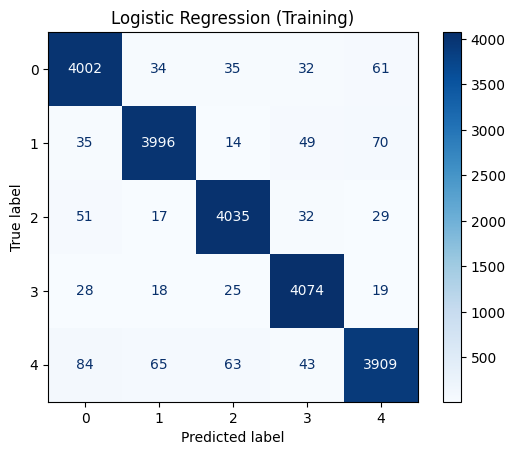

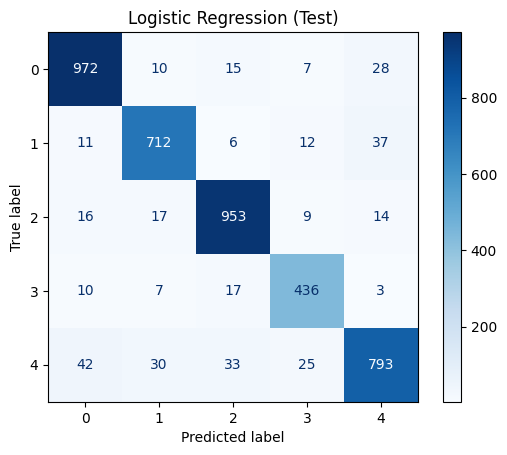

In [63]:
# Plot confusion matrices
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))


plot_confusion_matrix(train_y_smote, logreg_train_pred,  title="Logistic Regression (Training)")



plot_confusion_matrix(test_y, logreg_test_pred,  title="Logistic Regression (Test)")

In [64]:
with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(logreg, model_file)

In [66]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [68]:
%%writefile app.py
import streamlit as st
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Load the model and transformers from pickle files
with open('logistic_regression_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('count_vectorizer.pkl', 'rb') as cv_file:
    count_vect = pickle.load(cv_file)

with open('tfidf_transformer.pkl', 'rb') as tfidf_file:
    tfidf_transformer = pickle.load(tfidf_file)

# Function to make predictions
def predict_lr(text):
    Topic_names = {0: 'Bank Account services', 1: 'Credit card or prepaid card', 2: 'Others', 3: 'Theft/Dispute Reporting', 4: 'Mortgage/Loan'}
    X_new_counts = count_vect.transform([text])
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = model.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

# Streamlit UI
st.title("Complaint Tag Prediction")

# Text input for complaint
complaint = st.text_area("Enter the complaint text:")

# Button to make prediction
if st.button("Predict Tag"):
    if complaint:
        tag = predict_lr(complaint)
        st.write(f"The predicted tag is: {tag}")
    else:
        st.write("Please enter a complaint text.")

# Run the app with: streamlit run app.py


Writing app.py


In [74]:
%%writefile app.py
import streamlit as st
import pickle
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Paths to pickle files
model_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Ticket collection/deployment folder/logistic_regression_model (1).pkl'
cv_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Ticket collection/deployment folder/count_vectorizer (1).pkl'
tfidf_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Ticket collection/deployment folder/tfidf_transformer.pkl'

# Check if pickle files exist
if not all(os.path.isfile(path) for path in [model_path, cv_path, tfidf_path]):
    st.error("One or more required pickle files are missing.")
else:
    # Load the model and transformers from pickle files
    try:
        with open(model_path, 'rb') as model_file:
            model = pickle.load(model_file)

        with open(cv_path, 'rb') as cv_file:
            count_vect = pickle.load(cv_file)

        with open(tfidf_path, 'rb') as tfidf_file:
            tfidf_transformer = pickle.load(tfidf_file)
    except Exception as e:
        st.error(f"Error loading pickle files: {e}")

    # Function to make predictions
    def predict_lr(text):
        Topic_names = {0: 'Bank Account services', 1: 'Credit card or prepaid card', 2: 'Others', 3: 'Theft/Dispute Reporting', 4: 'Mortgage/Loan'}
        try:
            X_new_counts = count_vect.transform([text])
            X_new_tfidf = tfidf_transformer.transform(X_new_counts)
            predicted = model.predict(X_new_tfidf)
            return Topic_names.get(predicted[0], 'Unknown')
        except Exception as e:
            st.error(f"Error during prediction: {e}")
            return "Prediction error"

    # Streamlit UI
    st.title("Complaint Tag Prediction")

    # Text input for complaint
    complaint = st.text_area("Enter the complaint text:")

    # Button to make prediction
    if st.button("Predict Tag"):
        if complaint:
            tag = predict_lr(complaint)
            st.write(f"The predicted tag is: {tag}")
        else:
            st.write("Please enter a complaint text.")


Writing app.py


In [79]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = model.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [76]:
df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})

In [80]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Others
2,I want to open a salary account at your downto...,Account Services
3,"Yesterday, I received a fraudulent email regar...",Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Account Services
5,I need to know the number of bank branches and...,Account Services


In [81]:
import pickle

try:
    with open('/content/drive/MyDrive/Colab Notebooks/NLP/Ticket collection/deployment folder/logistic_regression_model (1).pkl', 'rb') as f:
        model = pickle.load(f)
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")

try:
    with open('/content/drive/MyDrive/Colab Notebooks/NLP/Ticket collection/deployment folder/count_vectorizer (1).pkl', 'rb') as f:
        count_vect = pickle.load(f)
    print("CountVectorizer loaded successfully")
except Exception as e:
    print(f"Error loading CountVectorizer: {e}")

try:
    with open('/content/drive/MyDrive/Colab Notebooks/NLP/Ticket collection/deployment folder/tfidf_transformer.pkl', 'rb') as f:
        tfidf_transformer = pickle.load(f)
    print("TfidfTransformer loaded successfully")
except Exception as e:
    print(f"Error loading TfidfTransformer: {e}")


Model loaded successfully
CountVectorizer loaded successfully
TfidfTransformer loaded successfully


In [83]:
%%writefile app.py
import streamlit as st
import pickle
import os

# Paths to pickle files
model_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Ticket collection/deployment folder/logistic_regression_model (1).pkl'
cv_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Ticket collection/deployment folder/count_vectorizer (1).pkl'
tfidf_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Ticket collection/deployment folder/tfidf_transformer.pkl'

# Debugging print statements
st.write(f"Checking files: {model_path}, {cv_path}, {tfidf_path}")

# Check if pickle files exist
files_missing = [path for path in [model_path, cv_path, tfidf_path] if not os.path.isfile(path)]

if files_missing:
    st.error(f"One or more required pickle files are missing: {', '.join(files_missing)}")
else:
    # Load the model and transformers from pickle files
    try:
        with open(model_path, 'rb') as model_file:
            model = pickle.load(model_file)

        with open(cv_path, 'rb') as cv_file:
            count_vect = pickle.load(cv_file)

        with open(tfidf_path, 'rb') as tfidf_file:
            tfidf_transformer = pickle.load(tfidf_file)
    except Exception as e:
        st.error(f"Error loading pickle files: {e}")

    # Function to make predictions
    def predict_lr(text):
        Topic_names = {0: 'Bank Account services', 1: 'Credit card or prepaid card', 2: 'Others', 3: 'Theft/Dispute Reporting', 4: 'Mortgage/Loan'}
        try:
            X_new_counts = count_vect.transform([text])
            X_new_tfidf = tfidf_transformer.transform(X_new_counts)
            predicted = model.predict(X_new_tfidf)
            return Topic_names.get(predicted[0], 'Unknown')
        except Exception as e:
            st.error(f"Error during prediction: {e}")
            return "Prediction error"

    # Streamlit UI
    st.title("Complaint Tag Prediction")

    # Text input for complaint
    complaint = st.text_area("Enter the complaint text:")

    # Button to make prediction
    if st.button("Predict Tag"):
        if complaint:
            tag = predict_lr(complaint)
            st.write(f"The predicted tag is: {tag}")
        else:
            st.write("Please enter a complaint text.")


Writing app.py


In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the Decision Tree Classifier with hyperparameters
dtc = DecisionTreeClassifier(random_state=40, max_depth=5, min_samples_split=10, min_samples_leaf=5)

# Fit the model on the training data
dtc.fit(train_X_smote, train_y_smote)


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=40)

In [85]:
# Make predictions on the training set
train_pred_dtc = dtc.predict(train_X_smote)
print("Classification Report (Training Set):")
print(classification_report(train_y_smote, train_pred_dtc))

# Make predictions on the test set
test_pred_dtc = dtc.predict(test_X)
print("Classification Report (Test Set):")
print(classification_report(test_y, test_pred_dtc))


Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      4164
           1       0.78      0.74      0.76      4164
           2       0.86      0.49      0.63      4164
           3       0.83      0.70      0.76      4164
           4       0.43      0.76      0.55      4164

    accuracy                           0.66     20820
   macro avg       0.72      0.66      0.67     20820
weighted avg       0.72      0.66      0.67     20820

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.71      0.59      0.64      1032
           1       0.71      0.71      0.71       778
           2       0.87      0.48      0.62      1009
           3       0.67      0.65      0.66       473
           4       0.41      0.70      0.52       923

    accuracy                           0.62      4215
   macro avg       0.68      0.62      0.63      4215
weigh

<Figure size 1200x600 with 0 Axes>

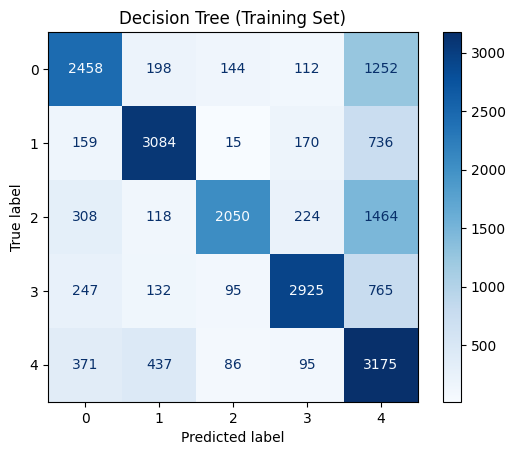

<Figure size 1200x600 with 0 Axes>

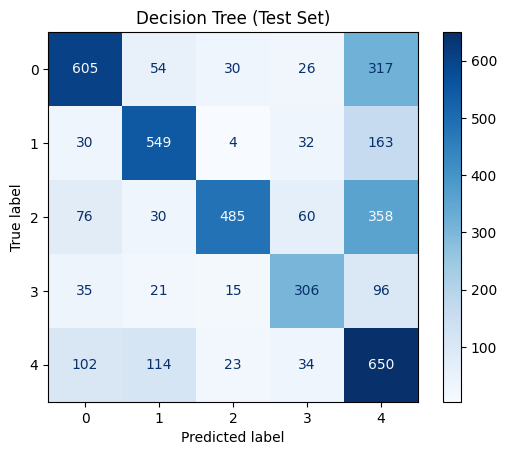

In [86]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for the training set
plt.figure(figsize=(12, 6))
plot_confusion_matrix(train_y_smote, train_pred_dtc, title="Decision Tree (Training Set)")

# Plot confusion matrix for the test set
plt.figure(figsize=(12, 6))
plot_confusion_matrix(test_y, test_pred_dtc, title="Decision Tree (Test Set)")


In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def print_metrics(y_true, y_pred, title, y_proba=None):
    print(f"{title} Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    if y_proba is not None:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_proba, multi_class='ovr'):.4f}")
    print("\n")


In [88]:
# Make predictions and calculate probabilities for the Decision Tree model
train_pred_dtc = dtc.predict(train_X_smote)
test_pred_dtc = dtc.predict(test_X)
train_proba_dtc = dtc.predict_proba(train_X_smote)  # If available
test_proba_dtc = dtc.predict_proba(test_X)  # If available

# Print metrics for Decision Tree model
print_metrics(train_y_smote, train_pred_dtc, "Decision Tree (Training)", train_proba_dtc)
print_metrics(test_y, test_pred_dtc, "Decision Tree (Test)", test_proba_dtc)


Decision Tree (Training) Metrics:
Accuracy: 0.6576
Precision: 0.7175
Recall: 0.6576
F1 Score: 0.6664
ROC AUC Score: 0.8794


Decision Tree (Test) Metrics:
Accuracy: 0.6157
Precision: 0.6799
Recall: 0.6157
F1 Score: 0.6243
ROC AUC Score: 0.8494




In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the Random Forest Classifier with hyperparameters
rfc = RandomForestClassifier(random_state=40, n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=5)

# Fit the model on the training data
rfc.fit(train_X_smote, train_y_smote)


RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=40)

In [90]:
# Make predictions on the training set
train_pred_rfc = rfc.predict(train_X_smote)
print("Classification Report (Training Set):")
print(classification_report(train_y_smote, train_pred_rfc))

# Make predictions on the test set
test_pred_rfc = rfc.predict(test_X)
print("Classification Report (Test Set):")
print(classification_report(test_y, test_pred_rfc))


Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      4164
           1       0.90      0.63      0.74      4164
           2       0.87      0.85      0.86      4164
           3       0.75      0.95      0.84      4164
           4       0.82      0.77      0.79      4164

    accuracy                           0.81     20820
   macro avg       0.82      0.81      0.81     20820
weighted avg       0.82      0.81      0.81     20820

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.77      0.87      0.81      1032
           1       0.84      0.55      0.66       778
           2       0.86      0.84      0.85      1009
           3       0.57      0.89      0.70       473
           4       0.78      0.69      0.73       923

    accuracy                           0.77      4215
   macro avg       0.76      0.77      0.75      4215
weigh

<Figure size 1200x600 with 0 Axes>

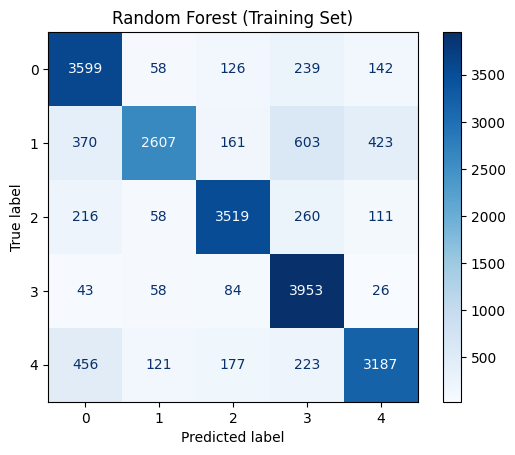

<Figure size 1200x600 with 0 Axes>

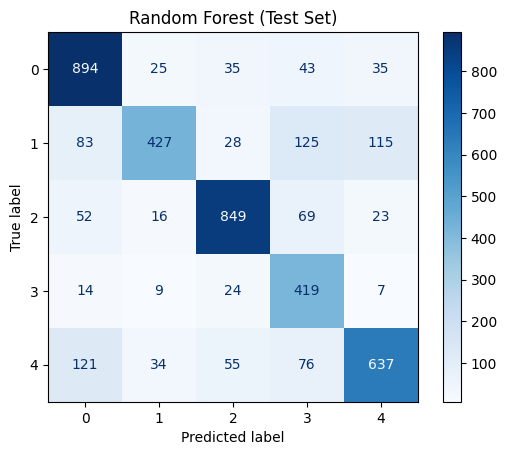

In [91]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for the training set
plt.figure(figsize=(12, 6))
plot_confusion_matrix(train_y_smote, train_pred_rfc, title="Random Forest (Training Set)")

# Plot confusion matrix for the test set
plt.figure(figsize=(12, 6))
plot_confusion_matrix(test_y, test_pred_rfc, title="Random Forest (Test Set)")


In [92]:
# Calculate probabilities for the Random Forest model
train_proba_rfc = rfc.predict_proba(train_X_smote)  # If available
test_proba_rfc = rfc.predict_proba(test_X)  # If available

# Print metrics for Random Forest model
print_metrics(train_y_smote, train_pred_rfc, "Random Forest (Training)", train_proba_rfc)
print_metrics(test_y, test_pred_rfc, "Random Forest (Test)", test_proba_rfc)


Random Forest (Training) Metrics:
Accuracy: 0.8100
Precision: 0.8201
Recall: 0.8100
F1 Score: 0.8071
ROC AUC Score: 0.9601


Random Forest (Test) Metrics:
Accuracy: 0.7654
Precision: 0.7823
Recall: 0.7654
F1 Score: 0.7632
ROC AUC Score: 0.9445




In [93]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the Multinomial Naive Bayes Classifier
mnb = MultinomialNB()

# Fit the model on the training data
mnb.fit(train_X_smote, train_y_smote)


MultinomialNB()

In [94]:
# Make predictions on the training set
train_pred_mnb = mnb.predict(train_X_smote)
print("Classification Report (Training Set):")
print(classification_report(train_y_smote, train_pred_mnb))

# Make predictions on the test set
test_pred_mnb = mnb.predict(test_X)
print("Classification Report (Test Set):")
print(classification_report(test_y, test_pred_mnb))


Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      4164
           1       0.80      0.78      0.79      4164
           2       0.87      0.86      0.86      4164
           3       0.88      0.86      0.87      4164
           4       0.82      0.81      0.82      4164

    accuracy                           0.84     20820
   macro avg       0.84      0.84      0.84     20820
weighted avg       0.84      0.84      0.84     20820

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1032
           1       0.69      0.67      0.68       778
           2       0.84      0.82      0.83      1009
           3       0.76      0.78      0.77       473
           4       0.75      0.72      0.74       923

    accuracy                           0.78      4215
   macro avg       0.77      0.77      0.77      4215
weigh

<Figure size 1200x600 with 0 Axes>

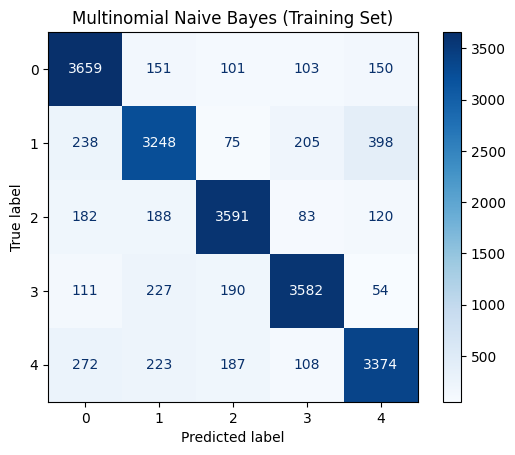

<Figure size 1200x600 with 0 Axes>

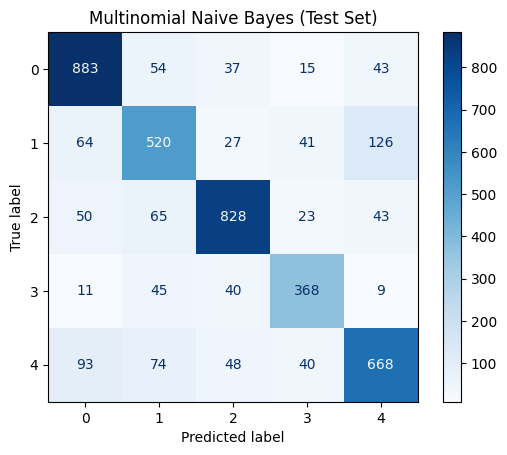

In [95]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for the training set
plt.figure(figsize=(12, 6))
plot_confusion_matrix(train_y_smote, train_pred_mnb, title="Multinomial Naive Bayes (Training Set)")

# Plot confusion matrix for the test set
plt.figure(figsize=(12, 6))
plot_confusion_matrix(test_y, test_pred_mnb, title="Multinomial Naive Bayes (Test Set)")


In [96]:
def print_metrics(y_true, y_pred, title, y_proba=None):
    print(f"{title} Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    if y_proba is not None:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_proba, multi_class='ovr'):.4f}")
    print("\n")

# Multinomial Naive Bayes does not provide probability estimates directly;
# however, you can use `predict_proba` if needed.
train_proba_mnb = mnb.predict_proba(train_X_smote)  # If available
test_proba_mnb = mnb.predict_proba(test_X)  # If available

# Print metrics for Multinomial Naive Bayes model
print_metrics(train_y_smote, train_pred_mnb, "Multinomial Naive Bayes (Training)", train_proba_mnb)
print_metrics(test_y, test_pred_mnb, "Multinomial Naive Bayes (Test)", test_proba_mnb)


Multinomial Naive Bayes (Training) Metrics:
Accuracy: 0.8383
Precision: 0.8385
Recall: 0.8383
F1 Score: 0.8382
ROC AUC Score: 0.9725


Multinomial Naive Bayes (Test) Metrics:
Accuracy: 0.7751
Precision: 0.7746
Recall: 0.7751
F1 Score: 0.7745
ROC AUC Score: 0.9505




In [97]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize the XGBoost Classifier with hyperparameters
xgb_model = xgb.XGBClassifier(
    random_state=40,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False
)

# Fit the model on the training data
xgb_model.fit(train_X_smote, train_y_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [98]:
# Make predictions on the training set
train_pred_xgb = xgb_model.predict(train_X_smote)
print("Classification Report (Training Set):")
print(classification_report(train_y_smote, train_pred_xgb))

# Make predictions on the test set
test_pred_xgb = xgb_model.predict(test_X)
print("Classification Report (Test Set):")
print(classification_report(test_y, test_pred_xgb))


Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4164
           1       0.98      0.98      0.98      4164
           2       0.98      0.97      0.97      4164
           3       0.98      0.98      0.98      4164
           4       0.96      0.95      0.96      4164

    accuracy                           0.97     20820
   macro avg       0.97      0.97      0.97     20820
weighted avg       0.97      0.97      0.97     20820

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1032
           1       0.88      0.91      0.90       778
           2       0.92      0.93      0.92      1009
           3       0.87      0.88      0.87       473
           4       0.87      0.84      0.85       923

    accuracy                           0.89      4215
   macro avg       0.89      0.89      0.89      4215
weigh

<Figure size 1200x600 with 0 Axes>

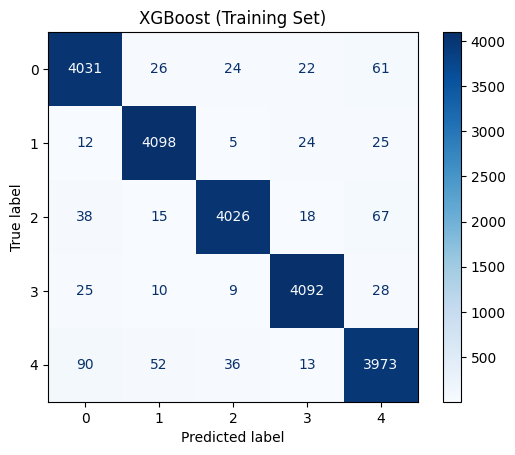

<Figure size 1200x600 with 0 Axes>

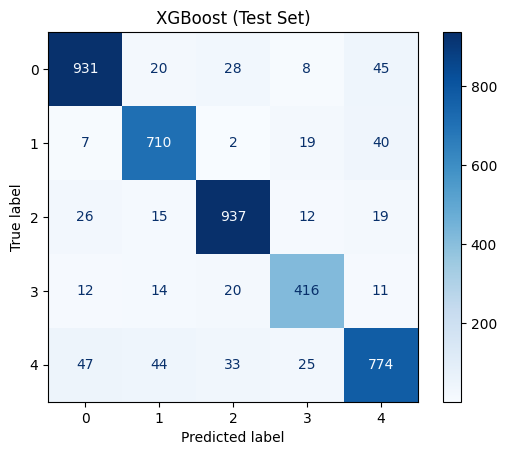

In [99]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for the training set
plt.figure(figsize=(12, 6))
plot_confusion_matrix(train_y_smote, train_pred_xgb, title="XGBoost (Training Set)")

# Plot confusion matrix for the test set
plt.figure(figsize=(12, 6))
plot_confusion_matrix(test_y, test_pred_xgb, title="XGBoost (Test Set)")


In [100]:
def print_metrics(y_true, y_pred, title, y_proba=None):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    print(f"{title} Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    if y_proba is not None:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_proba, multi_class='ovr'):.4f}")
    print("\n")

# XGBoost provides probability estimates
train_proba_xgb = xgb_model.predict_proba(train_X_smote)
test_proba_xgb = xgb_model.predict_proba(test_X)

# Print metrics for XGBoost model
print_metrics(train_y_smote, train_pred_xgb, "XGBoost (Training)", train_proba_xgb)
print_metrics(test_y, test_pred_xgb, "XGBoost (Test)", test_proba_xgb)


XGBoost (Training) Metrics:
Accuracy: 0.9712
Precision: 0.9712
Recall: 0.9712
F1 Score: 0.9712
ROC AUC Score: 0.9989


XGBoost (Test) Metrics:
Accuracy: 0.8940
Precision: 0.8938
Recall: 0.8940
F1 Score: 0.8938
ROC AUC Score: 0.9886




In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def compute_metrics(y_true, y_pred, y_proba=None):
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['Recall'] = recall_score(y_true, y_pred, average='weighted')
    metrics['F1 Score'] = f1_score(y_true, y_pred, average='weighted')
    if y_proba is not None:
        metrics['ROC AUC Score'] = roc_auc_score(y_true, y_proba, multi_class='ovr')
    else:
        metrics['ROC AUC Score'] = None
    return metrics



In [103]:
# Logistic Regression
logreg_metrics_train = compute_metrics(train_y_smote, logreg_train_pred, logreg_train_proba)
logreg_metrics_test = compute_metrics(test_y, logreg_test_pred, logreg_test_proba)

# Decision Tree
dtc_metrics_train = compute_metrics(train_y_smote, train_pred_dtc, train_proba_dtc)
dtc_metrics_test = compute_metrics(test_y, test_pred_dtc, test_proba_dtc)

# Random Forest
rfc_metrics_train = compute_metrics(train_y_smote, train_pred_rfc, train_proba_rfc)
rfc_metrics_test = compute_metrics(test_y, test_pred_rfc, test_proba_rfc)

# Multinomial Naive Bayes
mnb_metrics_train = compute_metrics(train_y_smote, train_pred_mnb, train_proba_mnb)
mnb_metrics_test = compute_metrics(test_y, test_pred_mnb, test_proba_mnb)

# XGBoost
xgb_metrics_train = compute_metrics(train_y_smote, train_pred_xgb, train_proba_xgb)
xgb_metrics_test = compute_metrics(test_y, test_pred_xgb, test_proba_xgb)


In [104]:
import pandas as pd

# Create a DataFrame to compare the models
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Multinomial Naive Bayes', 'XGBoost'],
    'Train Accuracy': [logreg_metrics_train['Accuracy'], dtc_metrics_train['Accuracy'], rfc_metrics_train['Accuracy'], mnb_metrics_train['Accuracy'], xgb_metrics_train['Accuracy']],
    'Test Accuracy': [logreg_metrics_test['Accuracy'], dtc_metrics_test['Accuracy'], rfc_metrics_test['Accuracy'], mnb_metrics_test['Accuracy'], xgb_metrics_test['Accuracy']],
    'Train Precision': [logreg_metrics_train['Precision'], dtc_metrics_train['Precision'], rfc_metrics_train['Precision'], mnb_metrics_train['Precision'], xgb_metrics_train['Precision']],
    'Test Precision': [logreg_metrics_test['Precision'], dtc_metrics_test['Precision'], rfc_metrics_test['Precision'], mnb_metrics_test['Precision'], xgb_metrics_test['Precision']],
    'Train Recall': [logreg_metrics_train['Recall'], dtc_metrics_train['Recall'], rfc_metrics_train['Recall'], mnb_metrics_train['Recall'], xgb_metrics_train['Recall']],
    'Test Recall': [logreg_metrics_test['Recall'], dtc_metrics_test['Recall'], rfc_metrics_test['Recall'], mnb_metrics_test['Recall'], xgb_metrics_test['Recall']],
    'Train F1 Score': [logreg_metrics_train['F1 Score'], dtc_metrics_train['F1 Score'], rfc_metrics_train['F1 Score'], mnb_metrics_train['F1 Score'], xgb_metrics_train['F1 Score']],
    'Test F1 Score': [logreg_metrics_test['F1 Score'], dtc_metrics_test['F1 Score'], rfc_metrics_test['F1 Score'], mnb_metrics_test['F1 Score'], xgb_metrics_test['F1 Score']],
    'Train ROC AUC Score': [logreg_metrics_train['ROC AUC Score'], dtc_metrics_train['ROC AUC Score'], rfc_metrics_train['ROC AUC Score'], mnb_metrics_train['ROC AUC Score'], xgb_metrics_train['ROC AUC Score']],
    'Test ROC AUC Score': [logreg_metrics_test['ROC AUC Score'], dtc_metrics_test['ROC AUC Score'], rfc_metrics_test['ROC AUC Score'], mnb_metrics_test['ROC AUC Score'], xgb_metrics_test['ROC AUC Score']]
})

# Display the DataFrame
print(metrics_df)


                     Model  Train Accuracy  Test Accuracy  Train Precision  \
0      Logistic Regression        0.961383       0.917200         0.961382   
1            Decision Tree        0.657637       0.615658         0.717519   
2            Random Forest        0.810038       0.765362         0.820082   
3  Multinomial Naive Bayes        0.838329       0.775089         0.838521   
4                  XGBoost        0.971182       0.893950         0.971214   

   Test Precision  Train Recall  Test Recall  Train F1 Score  Test F1 Score  \
0        0.917091      0.961383     0.917200        0.961347       0.916948   
1        0.679899      0.657637     0.615658        0.666410       0.624271   
2        0.782335      0.810038     0.765362        0.807061       0.763250   
3        0.774580      0.838329     0.775089        0.838154       0.774483   
4        0.893835      0.971182     0.893950        0.971179       0.893769   

   Train ROC AUC Score  Test ROC AUC Score  
0          

In [105]:
import xgboost as xgb
import pandas as pd

# Ensure you have the following:
# - count_vect: CountVectorizer object
# - tfidf_transformer: TfidfTransformer object
# - xgb_model: Trained XGBoost model

# Sample DataFrame with complaints
df_complaints = pd.DataFrame({
    'complaints': [
        "I can not get from chase who services my mortgage, who owns it and who has original loan docs",
        "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
        "I want to open a salary account at your downtown branch. Please provide me the procedure.",
        "Yesterday, I received a fraudulent email regarding renewal of my services.",
        "What is the procedure to know my CIBIL score?",
        "I need to know the number of bank branches and their locations in the city of Dubai"
    ]
})


In [106]:
# Transform the new text data
X_new_counts = count_vect.transform(df_complaints['complaints'])
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

In [107]:
# Make predictions using the XGBoost model
predictions = xgb_model.predict(X_new_tfidf)

In [108]:
# Define topic names
Topic_names = {
    0: 'Account Services',
    1: 'Others',
    2: 'Mortgage/Loan',
    3: 'Credit card or prepaid card',
    4: 'Theft/Dispute Reporting'
}

# Convert predictions to topic names
df_complaints['Predicted_Topic'] = [Topic_names[pred] for pred in predictions]

# Display the DataFrame with predictions
print(df_complaints)

                                          complaints          Predicted_Topic
0  I can not get from chase who services my mortg...            Mortgage/Loan
1  The bill amount of my credit card was debited ...                   Others
2  I want to open a salary account at your downto...         Account Services
3  Yesterday, I received a fraudulent email regar...  Theft/Dispute Reporting
4      What is the procedure to know my CIBIL score?         Account Services
5  I need to know the number of bank branches and...         Account Services


In [109]:
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Multinomial Naive Bayes', 'XGBoost'],
    'Train Accuracy': [logreg_metrics_train['Accuracy'], dtc_metrics_train['Accuracy'], rfc_metrics_train['Accuracy'], mnb_metrics_train['Accuracy'], xgb_metrics_train['Accuracy']],
    'Test Accuracy': [logreg_metrics_test['Accuracy'], dtc_metrics_test['Accuracy'], rfc_metrics_test['Accuracy'], mnb_metrics_test['Accuracy'], xgb_metrics_test['Accuracy']],
    'Train Precision': [logreg_metrics_train['Precision'], dtc_metrics_train['Precision'], rfc_metrics_train['Precision'], mnb_metrics_train['Precision'], xgb_metrics_train['Precision']],
    'Test Precision': [logreg_metrics_test['Precision'], dtc_metrics_test['Precision'], rfc_metrics_test['Precision'], mnb_metrics_test['Precision'], xgb_metrics_test['Precision']],
    'Train Recall': [logreg_metrics_train['Recall'], dtc_metrics_train['Recall'], rfc_metrics_train['Recall'], mnb_metrics_train['Recall'], xgb_metrics_train['Recall']],
    'Test Recall': [logreg_metrics_test['Recall'], dtc_metrics_test['Recall'], rfc_metrics_test['Recall'], mnb_metrics_test['Recall'], xgb_metrics_test['Recall']],
    'Train F1 Score': [logreg_metrics_train['F1 Score'], dtc_metrics_train['F1 Score'], rfc_metrics_train['F1 Score'], mnb_metrics_train['F1 Score'], xgb_metrics_train['F1 Score']],
    'Test F1 Score': [logreg_metrics_test['F1 Score'], dtc_metrics_test['F1 Score'], rfc_metrics_test['F1 Score'], mnb_metrics_test['F1 Score'], xgb_metrics_test['F1 Score']],
    'Train ROC AUC Score': [logreg_metrics_train['ROC AUC Score'], dtc_metrics_train['ROC AUC Score'], rfc_metrics_train['ROC AUC Score'], mnb_metrics_train['ROC AUC Score'], xgb_metrics_train['ROC AUC Score']],
    'Test ROC AUC Score': [logreg_metrics_test['ROC AUC Score'], dtc_metrics_test['ROC AUC Score'], rfc_metrics_test['ROC AUC Score'], mnb_metrics_test['ROC AUC Score'], xgb_metrics_test['ROC AUC Score']]
})

# Display the DataFrame with better formatting
print(metrics_df.to_string(index=False, float_format='{:.4f}'.format))

                  Model  Train Accuracy  Test Accuracy  Train Precision  Test Precision  Train Recall  Test Recall  Train F1 Score  Test F1 Score  Train ROC AUC Score  Test ROC AUC Score
    Logistic Regression          0.9614         0.9172           0.9614          0.9171        0.9614       0.9172          0.9613         0.9169               0.9979              0.9921
          Decision Tree          0.6576         0.6157           0.7175          0.6799        0.6576       0.6157          0.6664         0.6243               0.8794              0.8494
          Random Forest          0.8100         0.7654           0.8201          0.7823        0.8100       0.7654          0.8071         0.7632               0.9601              0.9445
Multinomial Naive Bayes          0.8383         0.7751           0.8385          0.7746        0.8383       0.7751          0.8382         0.7745               0.9725              0.9505
                XGBoost          0.9712         0.8940           

In [110]:
for idx, row in metrics_df.iterrows():
    model_name = row['Model']
    print(f"\n{model_name} Metrics:")
    print(f"  Train Accuracy: {row['Train Accuracy']:.4f}")
    print(f"  Test Accuracy: {row['Test Accuracy']:.4f}")
    print(f"  Train Precision: {row['Train Precision']:.4f}")
    print(f"  Test Precision: {row['Test Precision']:.4f}")
    print(f"  Train Recall: {row['Train Recall']:.4f}")
    print(f"  Test Recall: {row['Test Recall']:.4f}")
    print(f"  Train F1 Score: {row['Train F1 Score']:.4f}")
    print(f"  Test F1 Score: {row['Test F1 Score']:.4f}")
    print(f"  Train ROC AUC Score: {row['Train ROC AUC Score']:.4f}")
    print(f"  Test ROC AUC Score: {row['Test ROC AUC Score']:.4f}")


Logistic Regression Metrics:
  Train Accuracy: 0.9614
  Test Accuracy: 0.9172
  Train Precision: 0.9614
  Test Precision: 0.9171
  Train Recall: 0.9614
  Test Recall: 0.9172
  Train F1 Score: 0.9613
  Test F1 Score: 0.9169
  Train ROC AUC Score: 0.9979
  Test ROC AUC Score: 0.9921

Decision Tree Metrics:
  Train Accuracy: 0.6576
  Test Accuracy: 0.6157
  Train Precision: 0.7175
  Test Precision: 0.6799
  Train Recall: 0.6576
  Test Recall: 0.6157
  Train F1 Score: 0.6664
  Test F1 Score: 0.6243
  Train ROC AUC Score: 0.8794
  Test ROC AUC Score: 0.8494

Random Forest Metrics:
  Train Accuracy: 0.8100
  Test Accuracy: 0.7654
  Train Precision: 0.8201
  Test Precision: 0.7823
  Train Recall: 0.8100
  Test Recall: 0.7654
  Train F1 Score: 0.8071
  Test F1 Score: 0.7632
  Train ROC AUC Score: 0.9601
  Test ROC AUC Score: 0.9445

Multinomial Naive Bayes Metrics:
  Train Accuracy: 0.8383
  Test Accuracy: 0.7751
  Train Precision: 0.8385
  Test Precision: 0.7746
  Train Recall: 0.8383
  Test